# Topic Modelling climat

Ce notebook a pour objectif de regarde les sujets traiter par chacunes des communautés principales et
de les comparer à ce qui se fait dans les médias pro et climato_sc


In [2]:
%cd /
%cd /home/tanguyruault/Documents/Tanguy/hue

/
/home/tanguyruault/Documents/Tanguy/hue


In [3]:
#ouverture du fichier
with open('both_com_texte.txt', encoding = 'utf-8') as f:
    lines = f.readlines()

    


In [4]:
#### pour faciliter le traitement, on convertit le fichier en une liste de tokens que l'on découpe ensuite en fonction des lignes
file = []
for raw in lines :
    word = raw.split(" ")
    file.append(word)

In [8]:
import nltk
nltk.download('stopwords')
from gensim import corpora
from collections import defaultdict
from nltk.corpus import stopwords


#from spacy.lang.en import LOOKUP
from urllib.parse import urlparse

import argparse
import emoji
import gensim
import numpy as np
import pandas as pd
import re
import string

#on enlève dans un premier temps:
#mentions
#liens https
#ponctuations
#stopwords

#Methode perso
#d = re.sub(r'[^\w\s]', "", corpus)
#d =  re.sub(r'@([A-Za-z0-9]*):',"", d)
#d = re.sub(r'tx|\\n', "", d)
#mots clés en anglais

stopwords = set(stopwords.words('english'))
punct = set(string.punctuation)
clean = []

for element in file :# Convert unicode emoji to shortcode emoji
     element = emoji.demojize(str(element))
         
        # Remove all mentions (@) in the onon
     element = re.sub(r'@\S+ *', '', element)
          # Remove all hashtags (#) in the row
     element = re.sub(r'#\S+ *', '', element)
            #remove all rt in the row
     element = re.sub(r'rt', '',element)
    
   ####remove isolated numbers
     element = re.sub(r'\W+\d+', '', element)
     element = re.sub(r'[\\\;\']', '', element)
     #remove spaces pour prendre en compte les alphanum
     element = re.sub(r'\s', '', element)
     element = element.split(",")
         
        ###conversion en liste de element et de word en str

     element = [word.lower() for word in element if re.sub('\W', '', word)]
     #enlever les url
     #element = [word for word in element if not urlparse(word).scheme]
     #element = [str(word) for word in element]
     #element =   [char for char in element if char not in punct]
     #element = [' '.join(word) for word in element] 
     element = [word for word in element if word.isalpha()]
     element= [word for word in element if word not in stopwords]
     clean.append(element)
    
    


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tanguyruault/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
clean[2]

['sea', 'ice', 'still', 'formed', 'siberia', 'scientists', 'worried']

In [10]:
# remove words that appear only once
frequency = defaultdict(int)
for text in clean:
    for token in text:
        frequency[token] += 1
len(frequency)

46686

In [11]:
texts = [
    [token for token in text if frequency[token] > 1]
    for text in clean
]

In [12]:
from gensim import models
# Begin building the topic model
dictionary = corpora.Dictionary(texts)



In [13]:
# Print information on the document corpus
print("[INFO] Size of dictionary: {}".format(len(dictionary)))
# Convert the dictionary into a document term matrix
matrix = [dictionary.doc2bow(sent) for sent in texts]

[INFO] Size of dictionary: 30294


## Essai avec un seul dataset de topic

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

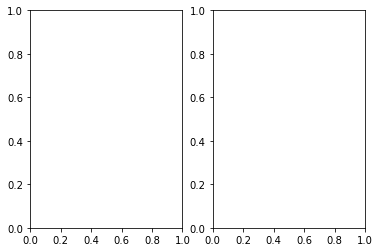

In [43]:
    # Initialize the LDA model from gensim
lda = gensim.models.ldamodel.LdaModel

# Train the model on the document term matrix
model = lda(matrix, num_topics=10, id2word=dictionary, passes=10,
            iterations=10)
    # Initialize the coherence evaluation model from gensim
cm = gensim.models.coherencemodel.CoherenceModel(model=model,
                                                 texts=texts,
                                                 coherence='c_v',
                                                 topn=10
                                                 )
    # Get the coherence of each topic and round the values : pour chaque itération, nombre de cohérences correspond au nombre de topics. 
values = cm.get_coherence_per_topic()
coherence = [round(score, 3) for score in values] 
    # Fixing random state for reproducibility
np.random.seed(19680801)
    
    ##on transforme la cohérence en array
coherence = np.array(coherence)
spread = coherence.std()
center = coherence.mean()
flier_high = coherence[len(coherence)-1]

flier_low = coherence[0]


fig, axs = plt.subplots(1,2)

# basic plot
axs[1,1].boxplot(data)
axs[1,1].set_title('basic plot')


In [34]:
print(spread)
print(center)
print(flier_high)
print(flier_low)



0.08642829397830319
0.3215
0.255
0.442


array([0.08642829, 0.3215    , 0.255     , 0.442     ])

### Avec un nombre fixe de topics

In [14]:
size = 9
# Initialize the LDA model from gensim
lda = gensim.models.ldamodel.LdaModel

# Train the model on the document term matrix
model = lda(matrix, num_topics=size, id2word=dictionary, passes=size,
            iterations=size)
    # Initialize the coherence evaluation model from gensim
cm = gensim.models.coherencemodel.CoherenceModel(model=model,
                                                 texts=texts,
                                                 coherence='c_v',
                                                 topn=size
                                                 )
    # Get the coherence of each topic and round the values : pour chaque itération, nombre de cohérences correspond au nombre de topics. 
values = cm.get_coherence_per_topic()
coherence = [round(score, 3) for score in values] 





In [ ]:
# notched plot
axs[0, 1].boxplot(data, 1)
axs[0, 1].set_title('notched plot')

# change outlier point symbols
axs[0, 2].boxplot(data, 0, 'gD')
axs[0, 2].set_title('change outlier\npoint symbols')

# don't show outlier points
axs[1, 0].boxplot(data, 0, '')
axs[1, 0].set_title("don't show\noutlier points")

# horizontal boxes
axs[1, 1].boxplot(data, 0, 'rs', 0)
axs[1, 1].set_title('horizontal boxes')

# change whisker length
axs[1, 2].boxplot(data, 0, 'rs', 0, 0.75)
axs[1, 2].set_title('change whisker length')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

# fake up some more data
spread = np.random.rand(50) * 100
center = np.ones(25) * 40
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
d2 = np.concatenate((spread, center, flier_high, flier_low))
# Making a 2-D array only works if all the columns are the
# same length.  If they are not, then use a list instead.
# This is actually more efficient because boxplot converts
# a 2-D array into a list of vectors internally anyway.
data = [data, d2, d2[::2]]

# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)

plt.show()

In [18]:
# Print topics
topics = model.show_topics(num_topics=size, num_words=size, formatted=True)
# Add a placeholder list to hold the final output
result = []

# Loop over the topics
for t in topics:

    # Assign the word string into their own variable
    words = t[1]

    # Split the words
    words = words.split(' + ')

    # Extract the words from the predictions
    words = [w.split('*')[1].strip('"') for w in words]

    # Append the row to the final result
    result.append(words)

# Convert the result into a NumPy array and transpose.
result = np.vstack(result).transpose()

# Append the coherence scores (Cv) to the matrix
result = np.vstack([result, coherence])

# Convert the result into a DataFrame
result = pd.DataFrame(result, columns=range(1, len(result)))
result

,1,2,3,4,5,6,7,8,9
0,ice,global,carbon,fossil,climate,new,via,climate,science
1,years,warming,emissions,fuel,change,energy,great,change,people
2,arctic,due,gas,every,action,time,look,crisis,say
3,sea,caused,extreme,get,policy,see,fire,need,know
4,last,level,weather,fuels,government,us,shows,world,think
5,greenhouse,nothing,oil,life,un,could,activists,make,like
6,human,cooling,arctic,less,trump,real,talk,fight,would
7,since,heat,temperature,humans,pa,repo,made,must,really
8,past,happening,fires,evidence,new,polar,kids,future,believe
9,0.471,0.426,0.3,0.368,0.357,0.274,0.256,0.432,0.421


In [22]:
%ls

 both_com_texte.csv                             'multilayer_test_th=20.csv'
 both_com_texte.txt                             'multilayer_th=2.csv'
'climateEdge_graph_01102019_30062020_th=2.csv'  'multlayer_test_th=10.csv'
 coherence0-10.png                              'tableau_tm_tnb=5.tex'
 multilayer_test1.csv


In [19]:
result.to_latex("tableau_tm_tnb=9.tex")

In [35]:


# Print out a LaTeX table
print(result.to_latex(na_rep='--', index=False))
In [ ]:

In [ ]:

In [39]:
sents = []
if len(row) > 0:
            row = row.split()
            sents.append(row)
Out[39]:
''
In [34]:
# calcul des bigrams
bigrams_list = []
for i in range(0 , len(text) - 1):
  bigram = text[i] + " " + text[i+1]
  bigrams_list.append(bigram)

print(bigrams_list[1])
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-34-44a097b82998> in <module>
      1 # calcul des bigrams
      2 bigrams_list = []
----> 3 for i in range(0 , len(text) - 1):
      4   bigram = text[i] + " " + text[i+1]
      5   bigrams_list.append(bigram)

NameError: name 'text' is not defined
In [95]:
#calcul des trigrams

trigrams_list = []
for i in range(0 , len(text) - 2):
  trigram = text[i] + " " + text[i+1] + " " + text[i+2]
  trigrams_list.append(trigram)

print(trigrams_list[2])
change predictive garbage
In [1]:
# Count word frequencies
frequency = defaultdict(int)
for token in text:
        frequency[token] += 1    
        
freq = pd.DataFrame.from_dict(frequency, orient = "index").sort_values(by=[0], ascending = False)
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-1-cdf0c2007d51> in <module>
      1 # Count word frequencies
----> 2 frequency = defaultdict(int)
      3 for token in text:
      4         frequency[token] += 1
      5 

NameError: name 'defaultdict' is not defined
In [102]:
# Count bigrams frequencies
bi_frequency = defaultdict(int)
for token in bigrams_list:
        bi_frequency[token] += 1
        
        
bi_freq = pd.DataFrame.from_dict(bi_frequency, orient = "index")
bi_freq= bi_freq.sort_values(by=[0], ascending = False)
Out[102]:
0
global warming	380
carbon tax	219
about climate	93
climate crisis	60
sea ice	57
...	...
sklippitt cosmic_engineer	21
trudeau liberals	21
polar bears	21
terrymorse stevecl58542482	21
change not	21
99 rows × 1 columns

In [33]:
# Count trigrams frequencies
tri_frequency = defaultdict(int)
for token in trigrams_list:
        tri_frequency[token] += 1
        
        
tri_freq = pd.DataFrame.from_dict(tri_frequency, orient = "index")
tri_freq = tri_freq.sort_values(by=[0], ascending = False)


# on remarque que c'est peu pertinent, on se concentre d'abord sur les mots et les bigrams
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-33-a4de6516e5f4> in <module>
      1 # Count trigrams frequencies
      2 tri_frequency = defaultdict(int)
----> 3 for token in trigrams_list:
      4         tri_frequency[token] += 1
      5 

NameError: name 'trigrams_list' is not defined
In [32]:

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-32-0921cf8e9781> in <module>
      2 
      3 
----> 4 frequency.doc2idx(["a", "a", "c", "not_in_dictionary", "c"])

AttributeError: 'collections.defaultdict' object has no attribute 'doc2idx'
In [32]:
# Count bigrams frequencies
frequency = defaultdict(int)
for token in bigrams_list:
        frequency[token] += 1
frequency
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-32-a97ed0b5eb1a> in <module>
      1 # Count bigrams frequencies
      2 frequency = defaultdict(int)
----> 3 for token in bigrams_list:
      4         frequency[token] += 1
      5 frequency

NameError: name 'bigrams_list' is not defined
In [36]:

Out[36]:
''
In [31]:
dictionary = corpora.Dictionary(sents)
Out[31]:
<gensim.corpora.dictionary.Dictionary at 0x1b11236b280>
In [29]:
matrix = [dictionary.doc2bow(sent) for sent in sents]
In [30]:

Out[30]:
[]
In [ ]:


SyntaxError: invalid syntax (<ipython-input-35-a5c848965d1e>, line 20)